<a href="https://colab.research.google.com/github/STRMNGnwo/Final-Year-Project/blob/main/SummerResearch_Custommodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mounting the Google Drive where the dataset is stored, after being processed by the Local stage of the pre-processing pipeline.**

In [ ]:
from google.colab import files
from google.colab import drive

#files.upload()

#g drive file path to total dataset /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/datasets
#g drive file path to split dataset /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Split_Patients
#g drive file path to split dataset /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/
drive.mount("/content/drive/")


# **Importing the required libraries**

In [ ]:
!pip install torchmetrics
#importing the required modules to create the U-Net model
import torch, torchvision
from torch.nn import Module
from torch.nn import Conv2d #The convolutional layer used in the U-Net architecture
from torch.nn import ReLU #activation function
from torch.nn import BatchNorm1d, BatchNorm2d
from torch.nn import Sequential
from torch.nn import functional as f #to make the fully connected layer
from torch.nn import ConvTranspose2d
from torch.nn import MaxPool2d #max pooling layer that is implemented after Conv2d layers
from torchvision import transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tqdm

import os
import sys

sys.path.insert(0, '/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/')

#from CustomDataset import SegmentationCTADataset
from CustomDataset_Simplified import CTADataset
#from split_patients import remove_DS_Store, split_patients, copy_collate_datasets

if torch.cuda.is_available():
  device=torch.device("cuda")
  torch.cuda.get_device_name(0)
  print("GPU")

else:
  device="cpu"
  print("CPU")



# **Importing the dataset data by unzipping the prepared dataset file in the Google Drive.**

The dataset has been split into train,test and val sets.

In [ ]:

!unzip /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Refined_Dataset.zip

#unzip /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Sample_Prepared_Dataset.zip

#unzip /content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/SampleTrain.zip


# **Sliding Window CNNS**

Sliding Window CNNs involve dividing an input image into "patches" of pixels, passing each pixel into a CNN, and assigning a class label to the pixel. Their main benefit is that they can localize, and they can also result in more training data being available as a result of the patches being made. However they are very slow and computationally expensive.

Localization -> assigning a class label to a region of pixels on a pixel-by-pixel basis.

Trade-off between localization accuracy and the context available to the CNN-> exists due to varying patch sizes. Large Patch sizes allow for greater context, but lower localization accuracy and vice-versa.

# **The U-NET Architecture:**

Consists of a contracting path that identifies context (descending/encoding) and a symmetrical expanding path that enables precise localization
of contours. U-NET is popular for medical image segmentation and is proven to be better than sliding window CNNs.

The Descending section:

The descending section of the architecture consists of convolutional layers that are followed by max-pooling layers .
This pattern (Conv,Conv,Max-Pool) repeats.
The input image is down-sampled (image size reduces but the number of channels increases).
After convolutions ->the number of channels seems to increase.
After max-pooling -> the image size decreases.

---------------------------
The Ascending section:

Consists of an expanding path, made up of convolutional layers and transposed convolutional layers(that upsample, ie increasing image size).
The Conv. layers in this section seem to reduce the number of channels


# **Building the Model**

# **The Block class**

Used by Encoder, Bottleneck and Decoder sections to performs Double Convolutions.

In [4]:
#Building block of both Encoder section and Decoder section.
#At a high level: Encoder= Block +downsampling (max_pooling), Decoder= upsampling+ skip connection concatenation + Block
# Block -> Double Convolutional layers, with Batch Normalisation and ReLU activation functions between them.
class Block(Module):

    def __init__(self, in_channels,out_channels):

        super().__init__()

        self.conv=Sequential(
            #Conv1
            #in_channels,out_channels,filter_size(kernel),stride,padding(same padding=1), bias
            Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False), # bias is false because batch normalisation is used in the next step and it cancels out bias
            BatchNorm2d(out_channels),
            ReLU(inplace=True),

            #Conv2
            Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False), #bias=False because batch normalisation is used in the next step and it cancels out bias
            BatchNorm2d(out_channels),
            ReLU(inplace=True)
        )

    def forward(self,x):
        return self.conv(x)

# The Encoder class

Represents the Encoder section of the U-NET architecture.

In [5]:
#the descending section made of conv.layers and max-pool layers.
#The Encoder consists of multiple "blocks"  which consist of down-sampling and convolutional layers.
#The Encoder reduces the spatial dimension and obtains information about the mask area/region of interest.
class Encoder(Module):

    def  __init__(self,encoding_channels=(1,64,128,256,512)): # default values for the encoding channels.

        super().__init__()

        self.channels=encoding_channels
        self.encoding_blocks=torch.nn.ModuleList()

        for i in range(0,len(self.channels)-1):
            in_channel=self.channels[i]
            out_channel=self.channels[i+1]
            self.encoding_blocks.append(Block(in_channel,out_channel)) #appending the convolution2d blocks of the encoder section to the modulelist

        self.pool= MaxPool2d(kernel_size=2,stride=2) #reduces spatial dimensions by a factor of 2 each time it is called


    def forward(self,x):
        #intermediary results between blocks (Skip Connections) are stored here
        block_outputs=[]

        for block in self.encoding_blocks:

            #print("Data before pooling and before convolutions",x.shape)
            x=block(x) # the block's forward method is implicitly called.

            #print("Data before pooling and after convolutions",x.shape)

            #adding the block output to the list
            block_outputs.append(x)

            #sending the output of the block to the max pooling layer
            x=self.pool(x)
            #print("Data after pooling",x.shape)

    #return the final form of the data and the intermediary results (skip-connections used in the Decoder section, in the U-NET architecture paper)
        return [x,block_outputs]


# **The Decoder class**

Represents the Decoder section of the U-NET architecture.

In [6]:
#The Decoder class has Decoder blocks to take in input data and skip connections, perform upsampling, concatenation of skip connection to data and Conv2D.
#The Decoder upsamples the localized information and provides context.
class Decoder(Module):

    def __init__(self,decoding_channels=(512,256,128,64,2)): #2 is the final one because of 2 classes-> TL and FL

        super().__init__()

        self.channels=decoding_channels
        self.decoding_blocks=torch.nn.ModuleList()

        #upsampling going to use transpose convolutional layers. Can also use bilinear + convolution
        self.upconvolutions=torch.nn.ModuleList()

        #making the up-sampling layers and the decoding blocks
        for i in range(0,len(decoding_channels)-1):
            in_channel=self.channels[i]
            out_channel=self.channels[i+1]
            self.decoding_blocks.append(Block(in_channel,out_channel))

            #NOTE due to the skip connections having to be added, would in_channel(first param below)  have to be *2
            self.upconvolutions.append(ConvTranspose2d(self.channels[i],self.channels[i+1],kernel_size=2,stride=2))


    def forward(self,x,encoder_intermediary_outputs):#encoder_intermediary_outputs are the list of skip connections from the encoder.

        #print("\n--------------Decoder------------------------")
        #print("Data in decoder")

        # for skipconnection in encoder_intermediary_outputs:
        #     print("Shape of skip connection: ",skipconnection.shape)

        for i in range (len(self.upconvolutions)):

            #print("Data shape before upsampling",x.shape)

            #using a transpose convolution to upsample the data (should )
            x=self.upconvolutions[i](x)

            #print("Data shape after upsampling",x.shape)

            #concatenating an intermediary output from encoder section to the data
            cropped_encoder_output=self.crop(encoder_intermediary_outputs[i],x)
            x=torch.cat([x,cropped_encoder_output],dim=1)

            #print("Data shape after concatenation with skip connection",x.shape)

            #sending the concatenated upsampled data through a decoding block
            x= self.decoding_blocks[i](x)
            #print("Data shape after upsampling, concatenation and convolution",x.shape)


        return x


    def crop(self, encoding_intermediary_output,x):

        #(_,_,H,W)=x.shape
        (_,_,H,W)=x.shape
        cropped_intermediary_output=torchvision.transforms.CenterCrop([H, W])(encoding_intermediary_output)

        return cropped_intermediary_output








# **The Bottleneck class**

Represents the Bottleneck section of the U-NET Architecture.

In [7]:
class Bottleneck(Module):

  def __init__(self, in_channels=None, out_channels=None):

    super().__init__()
    self.in_channels=in_channels
    self.out_channels=out_channels

    #bottleneck_block=Block(in_channels=encoder_intermediaries[::-1],out_channels=(encoder_intermediaries[::-1]*2))
    self.block=Block(self.in_channels,self.out_channels)

  def forward(self,x):
    return self.block(x)

# **The Custom Layer**

This layer is added before the final 1x1 conv layer and after the decoder layers.

It consists of the output from the decoder layer being subject to a dot product operation with a matrix of learnable weights. The result of the dot product operation is then convolved over by a 3x3 matrix of 1s to produce the expected output, which is then passed into the final 1x1 conv layer to produce the predicted segmentation maps.

In [8]:
class CustomLayer(Module): #class inherits from the Module class of torch.nn

  def __init__(self,in_channels=None,out_channels=None,output_shape=None):

    print("Initialising Custom Layer")
    super().__init__()
    self.in_channels=in_channels
    self.out_channels=out_channels

    self.weights_matrix_shape=output_shape

    #initially setting random weights matrix. Needs to be a trackable and trainable parameter
    #(Weights matrix as a parameter and its state would be maintained by PyTorch, updated during backprop)
    self.weights_matrix= torch.nn.Parameter(torch.rand(size=(self.weights_matrix_shape)) )#the 128,128 is the shape of the weight matrix which should be = to shape of image matrix.

    #seedable weights for the weights matrix, to ensure reproducability.

    #this should make the weights learnable and update them using autograd.
    self.weights_matrix.requires_grad=True


  def forward(self,data):

    #data matrix gets multiplied with the weights matrix (dot product) to produce a single value.
    #dot_product=np.dot(data,self.weights_matrix)


    element_wise_result=torch.mul(data,self.weights_matrix) #np.multiply(data,self.weights_matrix)

    #convolving the result over the static 3x3 kernel of 1s.

    #print("Element-wise multiplication shape: ",element_wise_result.shape)
    #print("Channels:",element_wise_result.shape[1])

    #I can either using a Conv2D operation or use the functional interface of Conv2D to explicitly specify the weights matrix

    #weight here is always going to be matrix of 1s.
    #Weight dimension: out_channels,in_channels,kernel width, kernel height
    ones_weight=torch.ones( size=(element_wise_result.shape[1],element_wise_result.shape[1],3,3))

    ones_weight=ones_weight.to(device)
    #print("Ones weights matrix shape: ",ones_weight.shape)
    #print("Ones weight unique",torch.unique(ones_weight))

    ones_conv_result=torch.nn.functional.conv2d(input=element_wise_result,weight=ones_weight,padding="same")

    return ones_conv_result




# **The U-NET class**

Acts as a wrapper for the entire U-NET architecture implementation, and contains instantiations of the Encoder, Bottleneck and Decoder sections. Also responsible for performing the final 1x1 convolution that outputs the predicted segmentation map/mask.

In [9]:
#Creating the U-NET class

#U-NET architecture:

"""
Consists of a contracting path that identifies context (descending/encoding) and a symmetrical expanding path that enables precise localization
of contours. U-NET is popular for medical image segmentation and is proven to be better than sliding window CNNs.

Localization -> assigning a class label to a region of pixels on a pixel-by-pixel basis.
"""

class UNet(Module):

    def __init__(self,encoding_channels=(1,64,128),decoding_channels=(256,128,64),seg_classes=3, retainDim=True, outSize=(128, 128)):

        #seg_classes is the number of classes that a pixel can belong to (2 being- TL and FL)
        #seg_classes is also the number of channels expected by the final conv layer which generates the map.

        #retainDim signifies if the original output dimension should be maintained or not when producing the map.

        super().__init__()

        #Encoder and Decoder are classes. Encoder is the descending section and the Decoder is the ascending of "U"
        self.encoder=Encoder(encoding_channels)
        self.bottleneck_block= Bottleneck(encoding_channels[-1],(encoding_channels[-1]*2) )
        self.decoder=Decoder(decoding_channels)

        self.retainDim=retainDim
        self.seg_classes=seg_classes
        self.outSize=outSize

        #defining the custom layer:
        self.custom_layer=CustomLayer(in_channels=decoding_channels[-1],out_channels=decoding_channels[-1],output_shape=outSize)

        #defining the last single convolutional layer, which would output the segmentation map
        #in_channel,out_channel,kernel_size
        self.head=Conv2d(decoding_channels[-1],seg_classes,1)

    def forward(self,x):
        #data's entry point into the model

        #get intermediary output from encoder, as calling it implicity calls its forward method
        encoder_results=self.encoder(x)
        #obtain the skip connections
        encoder_intermediaries=encoder_results[1]
        #obtain the image that needs to be sent into the bottleneck block ("between the Descending and Ascending sections")
        final_data_from_encoder=encoder_results[0]


        #print("Encoder output shape:",final_data_from_encoder.shape)

        # the "bottleneck" layer-> layer between encoder and decoder, which has a double conv2d.

        #passing in the final image output from the encoder into the bottleneck block (does 2 Conv2D convolutions)
        bottleneck_output=self.bottleneck_block(final_data_from_encoder)

        #passing in the encoder output in reverse(latest output to oldest output) as the data to its forward function
        #and also passing in the encoder outputs to decoder

        #decoder_output=self.decoder(encoder_intermediaries[::-1][0],encoder_intermediaries[::-1][1:])


        #print("Bottleneck block output shape:",bottleneck_output.shape)

        decoder_output=self.decoder(bottleneck_output,encoder_intermediaries[::-1])

        custom_layer_output= self.custom_layer(decoder_output)

        map = self.head(custom_layer_output)

        if self.retainDim:
            map = torch.nn.functional.interpolate(map, self.outSize)

        #print("The type of the model output is :",type(map))
        #print("The shape of the segmentation map is: ",map.shape)

        # return the segmentation map
        return map





# **Visualiser functions to display images**

In [10]:
def visualiser(image):

    print(type(image))
    if(type(image)==torch.Tensor):
        print("tensor")
        transform=transforms.ToPILImage()
        display=transform(image)
        display.show()

    elif(type(image)==Image.Image):
        print("image")
        image.show()

from numpy import ndarray
def visualiser_sample(image):
  print(type(image))

  if(type(image)==torch.Tensor):
    print("Image is in a tensor format")
    plt.imshow(image.permute(1, 2, 0))
    #plt.imshow(image)
    #plt.imshow((image* 255).astype(np.uint8))
    plt.show()

  if(type(image)==np.ndarray):
    print("Image is a numpy array")
    image=torch.from_numpy(image)
    plt.imshow(image)
    plt.imshow((image* 255).astype(np.uint8))
    plt.show()

def visualiser_colab(image):
  print(type(image))
  print("Image shape in visualiser_colab:",image.shape)

  if(type(image)==torch.Tensor):
    print("Image is in a tensor format")
    plt.imshow(image)
    plt.show()

  if(type(image)==np.ndarray):
    print("Image is a numpy array")
    image=torch.from_numpy(image)
    #plt.imshow(image.permute(1, 2, 0))
    plt.imshow(image)
    plt.show()


# **Creation of a Dataset class that represents the training dataset.**

The Semantically labelled segmentation maps/masks are generated during the instantiation of the Dataset class.

A cell to visualise the image, raw png mask and semantically labelled map has also been created.

In [11]:

from matplotlib import image
from matplotlib import pyplot
train_path="/content/Prepared_Dataset/train"
val_path="/content/Prepared_Dataset/val"
test_path="/content/Prepared_Dataset/test"

sample_path="/content/SampleTrain"

#specifying transforms-> increasing contrast in the image and converting it to a Tensor
train_transforms=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])

#Setting up Custom Datasets and converting appropriate images to Tensors.

train_dataset= CTADataset(os.path.join(train_path,"images"),os.path.join(train_path,"masks"),os.path.join(train_path,"normalised_masks"),transform=train_transforms)

#sample_dataset=CTADataset(os.path.join(sample_path,"images"),os.path.join(sample_path,"masks"),transform=train_transforms)



Sample image shape:  torch.Size([3, 128, 128])
sample map shape:  torch.Size([3, 128, 128])
Number of pixels in sample map:  <built-in method size of Tensor object at 0x7fa8f1d97ec0>
Length of sample dataset:  23844


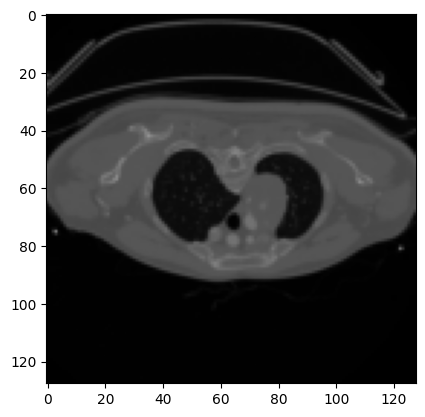

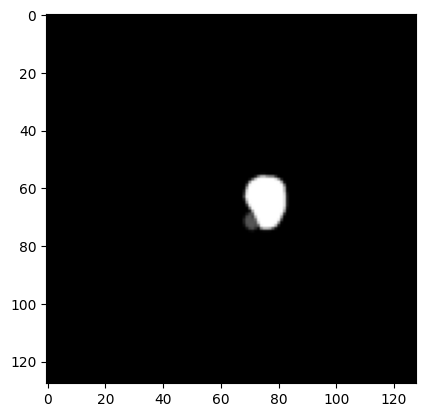

In [12]:
#getting a sample image and mask from an arbitrary patient and displaying it.
# target_map is the semantically segmented ground truth to be used in loss func
train_sampleimage,train_samplemask,train_normalisedmask,imagePath,maskPath=train_dataset.__getitem__(630)

print("Sample image shape: ",train_sampleimage.shape)
# image_np= np.asarray(train_sampleimage)

# print(image_np.size)
print("sample map shape: ",train_normalisedmask.shape)
print("Number of pixels in sample map: ",train_normalisedmask.size)


print("Length of sample dataset: ",train_dataset.__len__())
# visualiser_sample(train_sampleimage)
# visualiser_sample(train_samplemask)

pyplot.imshow(train_sampleimage.permute(1,2,0))
pyplot.show()
pyplot.imshow(train_normalisedmask.permute(1,2,0))
pyplot.show()

#for pyplot to show image, it must be in format: width,height. target map-> channel, width, height
#pyplot.imshow(np.squeeze(target_map)) #squeeze removes the channel dimension as its just 1



# **Creation of DataLoaders for the training dataset**

In [ ]:
#making dataloaders for the train, test and val sets.

#train_loader= DataLoader(train_dataset,batch_size=16,shuffle=False,drop_last=True)

shuffled_train_loader=DataLoader(train_dataset,batch_size=16,shuffle=True,drop_last=True)

# print(sample_dataset.__len__())

image,mask,normalisedmask,imagePath,maskPath= next(iter(shuffled_train_loader))

print("Image path: ",imagePath)
print("Mask path: ",maskPath)

print("Shape of image:", image.shape)
print("Shape of mask:", mask.shape)
print("Shape of normalised mask:", normalisedmask.shape)
print("Unique mask labels:", np.unique(mask))

#sample_loader=DataLoader(sample_dataset,batch_size=16,shuffle=False)



# **Instantiating the UNET implementation model**

Encoder:
Down-sample -> Max-pooling to reduce the size of the image.
Conv2D-> To increase the number of channels.

Decoder:
Up-Sample -> To increase the image size
Conv2D-> To decrease the number of channles

In [14]:
#Instantiate the Block, Encoder,Decoder and UNET classes. Pass data into the UNET Class (model's data entrypoint)
print("The device being used is: ",device)

seg_map_height=128
seg_map_width=128

#encoding_channels=(3,64,128),decoding_channels=(256,128,64,2)
UNET_Model= UNet(encoding_channels=(3,64,128,256,512),decoding_channels=(1024,512,256,128,64),outSize=(seg_map_height,seg_map_width),seg_classes=4)
UNET_Model.to(device)

print("Encoder channels: ",UNET_Model.encoder.channels)
print("Decoder Channels: ", UNET_Model.decoder.channels)

print(UNET_Model)


The device being used is:  cuda
Initialising Custom Layer
Encoder channels:  (3, 64, 128, 256, 512)
Decoder Channels:  (1024, 512, 256, 128, 64)
UNet(
  (encoder): Encoder(
    (encoding_blocks): ModuleList(
      (0): Block(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): 

# **Implementation of the Dice Score metric and the IoU metric**

In [62]:
#input parameters ->prediction_mask([channel,height,width])
def DCS_for_class(prediction_mask, true_mask, class_idx):
    eps = 1e-7

    #converting logits into probabilities
    pred_mask = torch.nn.functional.softmax(prediction_mask, dim=1)
    #considering only the channel that represents the class for which dice score is being calculated
    pred_mask = pred_mask[:, class_idx, :, :]
    #removing the 1 channel (class) from ground truth mask
    true_mask = true_mask.squeeze(1)

    #converting the ground truth semantically labeled mask into a one-hot encoded binary mask
    binary_true_mask = true_mask == class_idx

    #thresholding to convert probability into class
    intersection = (pred_mask > 0.5) & binary_true_mask
    intersection = intersection.float().sum()
    union = (pred_mask > 0.5).float().sum() + binary_true_mask.float().sum()

    dice_coeff = (2. * intersection + eps) / (union + eps)
    return dice_coeff.item()

def multi_class_dice_coefficient(pred_mask, true_mask, num_classes):

    DCS_per_class=[]
    #getting the dice score for every class
    for i in range(num_classes):
        DCS_per_class.append(DCS_for_class(pred_mask, true_mask, i))

    #length would be num_classes, in this case 4.
    return DCS_per_class


In [61]:
'''accuracy score functions'''
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex


def calc_IOU_for_epoch(predictions_list, target_maps_list):
#predictions_list -> list of predictions in an epoch
#target_maps_list -> list of target_maps(ground-truth) in an epoch
#predictions of shape -> [batch_size, channels(num of classes),width,height]
#target shape -> [batch_size,height,width] [height,width]= range(0,num_classes)

  mean_IOU_per_batch=[]
  IOU_Class0_per_batch=[]
  IOU_Class1_per_batch=[]
  IOU_Class2_per_batch=[]
  IOU_Class3_per_batch=[]

  for i in range(len(predictions_list)):
    #predictions list is 327 tensors, each of dimension: [batch,channels,width,height]

    #getting a single tensor and its corresponding ground truth mask
    prediction=predictions_list[i].cpu()
    target_map=target_maps_list[i].cpu()

    IOU_func= MulticlassJaccardIndex(num_classes=4,average="none")
    IOU_per_prediction= IOU_func(prediction,target_map)

    #per batch means per prediction -> mean is basically adding IoU for all classes in a prediction/4
    mean_IOU_per_batch.append(sum(IOU_per_prediction)/len(IOU_per_prediction))
    IOU_Class0_per_batch.append(IOU_per_prediction[0])
    IOU_Class1_per_batch.append(IOU_per_prediction[1])
    IOU_Class2_per_batch.append(IOU_per_prediction[2])
    IOU_Class3_per_batch.append(IOU_per_prediction[3])

    #print("IOU per class shape:",IOU_per_prediction.shape)

    #print("IOU Score per class for this batch of predicted maps is : ",IOU_per_prediction[0], IOU_per_prediction[1], IOU_per_prediction[2])


  IOU_for_epoch=[]

  '''average mean IOU(IOU class1+IOU class2+IOU class3/num_classes) across epoch'''
  IOU_for_epoch.append(sum(mean_IOU_per_batch)/len(mean_IOU_per_batch))
  ''' average IOU for class 0 across epoch'''
  IOU_for_epoch.append(sum(IOU_Class0_per_batch)/len(IOU_Class0_per_batch))
  ''' average IOU for class 1 across epoch'''
  IOU_for_epoch.append(sum(IOU_Class1_per_batch)/len(IOU_Class1_per_batch))
  ''' average IOU for class 2 across epoch'''
  IOU_for_epoch.append(sum(IOU_Class2_per_batch)/len(IOU_Class2_per_batch))
  ''' average IOU for class 3 across epoch'''
  IOU_for_epoch.append(sum(IOU_Class3_per_batch)/len(IOU_Class3_per_batch))

  return IOU_for_epoch
  #IOU_per epoch is a list:
  #[mean_IOU_across_predictions,mean_IOU_class1_across_predictions, ..classn_across_predictions]


def calc_Dice_for_epoch (predictions_list, target_maps_list):

  #dice_func=Dice(num_classes=3, average='none')
  mean_DCS_per_batch=[]
  DCS_Class0_per_batch=[]
  DCS_Class1_per_batch=[]
  DCS_Class2_per_batch=[]
  DCS_Class3_per_batch=[]

  for i in range(len(predictions_list)):

    #predictions list is 327 tensors, each of dimension: [batch,channels,width,height]
    #getting a single tensor and its corresponding ground truth mask
    prediction=predictions_list[i].cpu()
    target_map=target_maps_list[i].cpu()

    #sending prediction of dimension:[batch,channels,width,height], and mask and number of classes for segmentation
    DCS_per_prediction= multi_class_dice_coefficient(prediction,target_map,4)

    #average of the DCS across the 4 classes
    mean_DCS_per_batch.append(sum(DCS_per_prediction)/len(DCS_per_prediction))

    DCS_Class0_per_batch.append(DCS_per_prediction[0])
    DCS_Class1_per_batch.append(DCS_per_prediction[1])
    DCS_Class2_per_batch.append(DCS_per_prediction[2])
    DCS_Class3_per_batch.append(DCS_per_prediction[3])


  DCS_for_epoch=[]

  '''Average DCS across 4 classes, for this epoch'''
  DCS_for_epoch.append(sum(mean_DCS_per_batch)/len(mean_DCS_per_batch))
  '''Average DCS for Class 0 (Background) for this epoch:'''
  DCS_for_epoch.append(sum(DCS_Class0_per_batch)/len(DCS_Class0_per_batch))
  '''Average DCS for Class 1 (FL) for this epoch:'''
  DCS_for_epoch.append(sum(DCS_Class1_per_batch)/len(DCS_Class1_per_batch))
  '''Average DCS for Class 2 (TL) for this epoch:'''
  DCS_for_epoch.append(sum(DCS_Class2_per_batch)/len(DCS_Class2_per_batch))
  '''Average DCS for Class 3 (FLT) for this epoch:'''
  DCS_for_epoch.append(sum(DCS_Class3_per_batch)/len(DCS_Class3_per_batch))


  return DCS_for_epoch




# **Defining the model's hyper-parameters:**

In [22]:
#defining and initialising model hyper-parameters

initial_learning_rate=0.0001

#Optimizer function -> Adam

model_params=UNET_Model.parameters()
print(type(UNET_Model.parameters))

for name,param in UNET_Model.named_parameters():
  if param.requires_grad==True:
    print(name)

print("Model Parameters: ", model_params)


#need to optimise UNET_Model params (all the Conv2D weights) AND the custom layer weight matrix.
optimizer_function= torch.optim.Adam(params=UNET_Model.parameters(),lr=initial_learning_rate)

batch_size=16

num_epochs=10

training_loss_list=[]

#loss_func= binary_cross_entropy
#loss_function=torch.nn.BCEWithLogitsLoss()

#loss_func= cross_entropy (as its a 3 class pixel classification problem)

'''
for CrossEntropyLoss to work, expected mask/target should be either
Class indices in the range [0,C) where C is the number of classes or
Probabilities for each class
'''

#What I think is happening:
'''
Mask data does not contain classes assigned to pixels. It is simply rgb pixel values.

image and mask values have been normalized from (0 to 255) to (0,1)
so what if CrossEntropyLoss is assuming them to be probability values and as all the values are between
0 and 1 (like 0.2, 0.3, 0.5) it is flooring them to be class 0?.

'''

loss_function=torch.nn.CrossEntropyLoss()



<class 'method'>
encoder.encoding_blocks.0.conv.0.weight
encoder.encoding_blocks.0.conv.1.weight
encoder.encoding_blocks.0.conv.1.bias
encoder.encoding_blocks.0.conv.3.weight
encoder.encoding_blocks.0.conv.4.weight
encoder.encoding_blocks.0.conv.4.bias
encoder.encoding_blocks.1.conv.0.weight
encoder.encoding_blocks.1.conv.1.weight
encoder.encoding_blocks.1.conv.1.bias
encoder.encoding_blocks.1.conv.3.weight
encoder.encoding_blocks.1.conv.4.weight
encoder.encoding_blocks.1.conv.4.bias
encoder.encoding_blocks.2.conv.0.weight
encoder.encoding_blocks.2.conv.1.weight
encoder.encoding_blocks.2.conv.1.bias
encoder.encoding_blocks.2.conv.3.weight
encoder.encoding_blocks.2.conv.4.weight
encoder.encoding_blocks.2.conv.4.bias
encoder.encoding_blocks.3.conv.0.weight
encoder.encoding_blocks.3.conv.1.weight
encoder.encoding_blocks.3.conv.1.bias
encoder.encoding_blocks.3.conv.3.weight
encoder.encoding_blocks.3.conv.4.weight
encoder.encoding_blocks.3.conv.4.bias
bottleneck_block.block.conv.0.weight
bo

# **Training the model on the training samples.**

Calculating loss/error using the loss function.
Backpropagating the error through the model, to readjust weights.
Displaying the Dice score and IoU score per epoch


In [23]:
model=torch.load("/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Full_dataset_saved_models/SummerResearch/custom_model-fulldataset_Seed7-10epochs")


In [ ]:
IOU_per_epoch=[]
DCS_per_epoch=[]

#Training

#epoch -> entire run of a CNN through an entire training dataset.
#enumeration of a data loader-> passing batches of data to train the model, backpropogate error and optimise weights

for i in range(0,num_epochs+1):
  #setting the model mode to train
  UNET_Model.train()
  images_path_list=[]
  masks_path_list=[]

  images_list=[]
  masks_list=[]

  predictions_list=[]
  normalised_maps_list=[]

  #looping through batches of data made by the training DataLoader.
  for (batch_index,(image,mask,normalisedmap,imagePath,maskPath)) in tqdm.tqdm(enumerate(shuffled_train_loader),total=len(shuffled_train_loader)):

    #switching the data over to the GPU
    image=image.to(device)
    mask=mask.to(device)
    #forcing the conversion to long
    mask=mask.long()



    #adding images and masks in this list to batch
    images_list.append(image)
    masks_list.append(mask)
    normalised_maps_list.append(normalisedmap)
    images_path_list.append(imagePath)
    masks_path_list.append(maskPath)

    #making the prediction for the input image
    #predictions=UNET_Model(image)

    predictions=model(image)
    # moving predictions to cpu and appending it to list, to see if it prevents CUDA out of memory.
    predictions_list.append(predictions.cpu())

    #predictions_list.append(predictions)

    #Calculating loss

    loss=loss_function(predictions,mask)
    training_loss_list.append(loss.item())

    #zeroing out accumulated gradients as weights have already been modified according to them during the previous run.
    optimizer_function.zero_grad()

    #Back propogation:
    loss.backward()

    #updating weights
    optimizer_function.step()

  '''calculate IOU per epoch'''
  #end of epoch loop
  IOU_per_epoch.append(calc_IOU_for_epoch(predictions_list,masks_list))
  print(f"----------------------After epoch {i}------------------------------------------")
  print(IOU_per_epoch)
  print(f"At end of epoch {i}, the mean IOU across 3 classes is: ",IOU_per_epoch[i-1][0])
  print(f"At end of epoch {i}, the mean IOU for class 0 is: ",IOU_per_epoch[i-1][1] )
  print(f"At end of epoch {i}, the mean IOU for class 1 is: ",IOU_per_epoch[i-1][2] )
  print(f"At end of epoch {i}, the mean IOU for class 2 is: ",IOU_per_epoch[i-1][3] )
  print(f"At end of epoch {i}, the mean IOU for class 3 is: ",IOU_per_epoch[i-1][4] )

  '''calculate Dice Score per epoch'''
  DCS_per_epoch.append(calc_Dice_for_epoch(predictions_list,masks_list))

  print("\n")
  print(DCS_per_epoch)
  print(f"At end of epoch {i}, the mean DCS across 3 classes is: ",DCS_per_epoch[i-1][0])
  print(f"At end of epoch {i}, the mean DCS for class 0 is: ",DCS_per_epoch[i-1][1] )
  print(f"At end of epoch {i}, the mean DCS for class 1 is: ",DCS_per_epoch[i-1][2] )
  print(f"At end of epoch {i}, the mean DCS for class 2 is: ",DCS_per_epoch[i-1][3] )
  print(f"At end of epoch {i}, the mean DCS for class 3 is: ",DCS_per_epoch[i-1][4] )

  #saving the model every 10 epochs.
  if(i%10==0):
    #SAVING THE MODEL
    print("Saving the model at epoch: ",i)
    save_path="/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Full_dataset_saved_models/SummerResearch/custom_model-fulldataset_Seed7-{}epochs"
    path=save_path.format(i)
    torch.save(UNET_Model,path)

print("Ended training phase")
print("Training losses are as follows: ",training_loss_list)

##NOTE: Images are represented during training in the format: [batchsize,channels,height,width]

#displaying the predicted mask and the actual mask
print("The data type of the prediction is : ",type(predictions))



# **Visualising some of the predictions made during training.**

In [ ]:
#array[0][:][:][:]
#print("Image paths stored",len(images_path_list))
#print("Mask paths stored",len(masks_path_list))

print("Predictions stored: ",len(predictions_list))
print("Predictions(from model) shape:",predictions.shape)

print("Images stored",len(images_list))
print("Masks stored",len(masks_list))
print("Target maps stored", len(normalised_maps_list))

#getting a certain index of predictions,images and masks.
list_index=420
image=images_list[list_index]
mask= masks_list[list_index]
predictions=predictions_list[list_index]
target_map=normalised_maps_list[list_index]

#to convert tensor to numpy array to plot, switch it from gpu to cpu
mask=mask.cpu()
predictions=predictions.cpu()
image=image.cpu()
target_map=target_map.cpu()

print("Shape of the Image from list : ", image.shape)
print("Shape of the expected mask from list: ", mask.shape)
print("Shape of the predictions from list: ", predictions.shape)
print("Shape of the target_maps from list: ",target_map.shape)
# print("Image used: ",images_path_list[list_index])
# print("Mask used: ",masks_path_list[list_index])


batch=batch_size-1

#taking a single image from the batch of images,
#permuting it to display it and then displaying the input image using pyplot's imshow function.
print("Input image")
image=image[batch][:][:][:]
image=image.permute(1,2,0)
plt.imshow(image.detach().numpy())
plt.show()

#reading in mask 1, from the batch of 32.
#Also permuting it, so shape becomes [height,width,channel]
'''print("Expected mask")
mask=mask[batch][:][:][:]
mask=mask.permute(1,2,0)
plt.imshow(mask.detach().numpy())
plt.show()'''


print("Ground truth target mask passed into loss func:")
individual_target_map=target_map[batch][:][:]
visualiser_colab(individual_target_map.permute(1,2,0))
print("The Model output mask")

print("Prediction type from list : ",type(predictions))

#reading in prediction 1, from the batch of 32
#also permuting it so shape becomes [height,width,channel]
individual_prediction=predictions[batch][:][:][:]
print("predictions shape before being displayed: ",individual_prediction.shape)
individual_prediction=individual_prediction.permute(1,2,0) #shape becomes 128,128,3
print("Predictions shape after permuting it:",individual_prediction.shape)
# predictions=transf(predictions)
visualiser_colab(individual_prediction.detach().numpy())


print("Predictions values", torch.unique(individual_prediction))

print("Target_map unique values: ",torch.unique(individual_target_map))


In [ ]:
#SAVING THE MODEL
path="/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/<enter name of model>"
torch.save(UNET_Model,path)

# **Validating the model by loading it and testing it on unseen data.**

In [51]:
model=torch.load("/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Full_dataset_saved_models/SummerResearch/custom_model-fulldataset_Seed7-10epochs(stopped))")
model.eval()

#model2=torch.load("/content/drive/MyDrive/FYP-Aortic_Dissection_Segmentation/Full_dataset_saved_models/shuffled_trained_models/shuffled_trained_model-fulldataset_Seed7-50epochs")
#model2.eval()

UNet(
  (encoder): Encoder(
    (encoding_blocks): ModuleList(
      (0): Block(
        (conv): Sequential(
          (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (1): Block(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

# **Evaluating the model on the testing set:**

In [39]:
test_path="/content/Prepared_Dataset/test"

test_transforms=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])

test_dataset=CTADataset(os.path.join(test_path,"images"),os.path.join(test_path,"masks"),os.path.join(test_path,"normalised_masks"),transform=test_transforms)

test_loader= DataLoader(test_dataset,batch_size=16,shuffle=True,drop_last=True)
print("Length of test dataloader: ",len(test_loader))
print("Length of test dataset: ",len(test_dataset))

Length of test dataloader:  327
Length of test dataset:  5236


In [63]:
images_list=[]
masks_list=[]
image_path_list=[]
mask_path_list=[]
target_maps_list=[]
predictions_list=[]
predictions2_list=[]

with torch.no_grad():

  for (batch_index,(image,mask,normalisedmask,imagePath,maskPath)) in tqdm.tqdm(enumerate(test_loader),total=len(test_loader)):

      #switching the data over to the GPU
      image=image.to(device)
      mask=mask.to(device)
      mask=mask.long()
      #somehow target_map becomes a tensor from a np array. values still remain the same (0,1,2)
      #shape of target-> batch, 1(channel), width, height

      '''target_map= torch.squeeze(target_map) #removing the 1 channel this is because CELoss expects form->[N, H, W]
      #print("target_map dimension",target_map.shape)
      target_map=target_map.to(dtype=torch.long)
      target_map=target_map.to(device) '''


      #adding images and masks in this list to batch
      images_list.append(image)
      masks_list.append(mask)
      image_path_list.append(imagePath)
      mask_path_list.append(maskPath)

      target_maps_list.append(normalisedmask)

      predictions=model(image)
      #predictions2=model2(image)

      predictions_list.append(predictions)
      #predictions2_list.append(predictions2)






IOU_per_epoch=calc_IOU_for_epoch(predictions_list,masks_list)
print(IOU_per_epoch)
print(f"----------------------After end of testing------------------------------------------")
print(f"The mean IOU across 4 classes is: ",IOU_per_epoch[0])
print(f"The mean IOU for class 0(Background) is: ",IOU_per_epoch[1] )
print(f"The mean IOU for class 1(TL) is: ",IOU_per_epoch[2] )
print(f"The mean IOU for class 2(FL) is: ",IOU_per_epoch[3] )
print(f"The mean IOU for class 3(FLT) is: ",IOU_per_epoch[4] )

'''calculate Dice Score per epoch'''
DCS_per_epoch=calc_Dice_for_epoch(predictions_list,masks_list)

print(DCS_per_epoch)
print("\n")
print(f"The mean DCS across 4 classes is: ",DCS_per_epoch[0])
print(f"The mean DCS for class 0(Background) is: ",DCS_per_epoch[1] )
print(f"The mean DCS for class 1(FL) is: ",DCS_per_epoch[2] )
print(f"The mean DCS for class 2(TL) is: ",DCS_per_epoch[3] )
print(f"The mean DCS for class 3(FLT) is: ",DCS_per_epoch[4] )


100%|██████████| 327/327 [02:24<00:00,  2.26it/s]


[tensor(0.5535), tensor(0.9985), tensor(0.6247), tensor(0.5909), tensor(0.)]
----------------------After end of testing------------------------------------------
The mean IOU across 4 classes is:  tensor(0.5535)
The mean IOU for class 0(Background) is:  tensor(0.9985)
The mean IOU for class 1(TL) is:  tensor(0.6247)
The mean IOU for class 2(FL) is:  tensor(0.5909)
The mean IOU for class 3(FLT) is:  tensor(0.)
[0.457106364820732, 0.9992610052091266, 0.7557699530861064, 1.4302618160073944e-10, 0.07339450084466848]


The mean DCS across 4 classes is:  0.457106364820732
The mean DCS for class 0(Background) is:  0.9992610052091266
The mean DCS for class 1(FL) is:  0.7557699530861064
The mean DCS for class 2(TL) is:  1.4302618160073944e-10
The mean DCS for class 3(FLT) is:  0.07339450084466848


# **Visualising some of the predictions made**, along with input images.

Input image


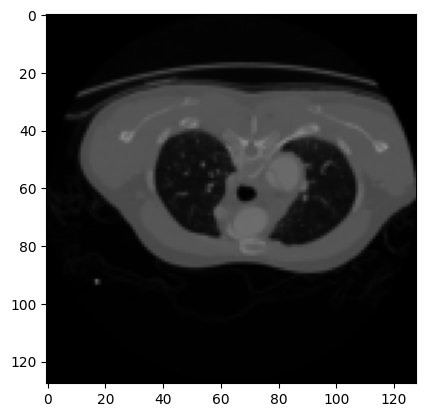

Expected mask


In [64]:
##displaying images,masks, labelled masks and predictions from test set
list_index=60


#getting a certain index of predictions,images and masks.
image=images_list[list_index]
mask= masks_list[list_index]
predictions=predictions_list[list_index]
target_map=target_maps_list[list_index]

#to convert tensor to numpy array to plot, switch it from gpu to cpu
mask=mask.cpu()
predictions=predictions.cpu()


image=image.cpu()
target_map=target_map.cpu()

batch=batch_size-1

#taking a single image from the batch of images,
#permuting it to display it and then displaying the input image using pyplot's imshow function.
print("Input image")
image=image[batch][:][:][:]
image=image.permute(1,2,0)
plt.imshow(image.detach().numpy())
plt.show()

#reading in mask 1, from the batch of 32.
#Also permuting it, so shape becomes [height,width,channel]
print("Expected mask")
mask=mask[batch][:][:][:]
#visualise_mask=mask.permute(1,2,0)



Ground truth target mask:
<class 'torch.Tensor'>
Image shape in visualiser_colab: torch.Size([128, 128, 3])
Image is in a tensor format


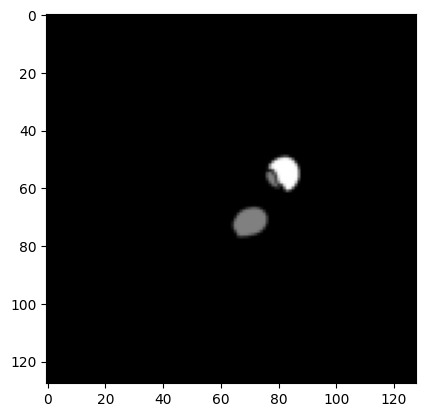

The Model output mask
predictions shape before being displayed:  torch.Size([4, 128, 128])
Predictions shape after permuting it: torch.Size([128, 128, 4])
tensor([-8.4540e+02, -8.4368e+02, -8.0378e+02,  ...,  6.7821e-01,
         6.7822e-01,  6.7828e-01])


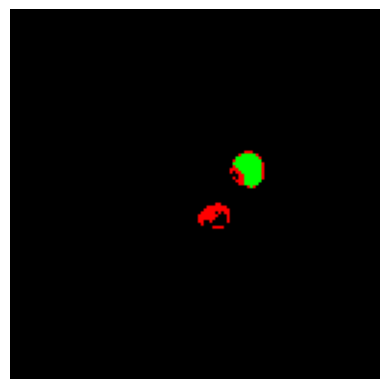

torch.Size([4, 128, 128])
torch.Size([128, 128])
Dice scores:
[0.9991964101791382, 0.874015748500824, 1.4285714833306429e-09, 1.0]
Visualising segments on the original CTA image


In [65]:
import cv2 as cv

print("Ground truth target mask:")
individual_target_map=target_map[batch][:][:]
visualise_target_map=individual_target_map.permute(1,2,0)
visualiser_colab(visualise_target_map)

print("The Model output mask")
#reading in prediction 1, from the batch of 32
#also permuting it so shape becomes [height,width,channel]
individual_prediction=predictions[batch][:][:][:]
print("predictions shape before being displayed: ",individual_prediction.shape)

#code to convert 4 channels to 3 channels (output is 4 channels because of 4 classes)
#individual_prediction = individual_prediction[:3,:,:]
prediction=individual_prediction.permute(1,2,0) #shape becomes 128,128,3

print("Predictions shape after permuting it:",prediction.shape)

#NOTE: Issue printing out the images now, not sure why. Values being output by model doesn't seem to be rgb values.
prediction_vis=cv.normalize(prediction.detach().numpy(), None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
#plt.imshow(prediction_vis)
#plt.show()


# 4-channel image is stored in the variable 'prediction'
# 'prediction' should have shape (height, width, 4)

# Define a color map for each label
label_colors = [
    [0, 0, 0],        # Background (black)
    [255, 0, 0],      # Label 1 (red)
    [0, 255, 0],      # Label 2 (green)
    [0, 0, 255],      # Label 3 (blue)
]

# Create an empty RGB image of dimension
rgb_image = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)

#converting logits into probabilities
'''prediction = torch.nn.functional.softmax(prediction, dim=1)
prediction= (prediction > 0.5)

print("Unique: ",np.unique(np.asarray(prediction)))'''
print(torch.unique(prediction))
# Overlay each label with its corresponding color
for i in range(4):
    label_mask = prediction[:, :, i] > 0  # Mask for the current label
    rgb_image[label_mask] = label_colors[i]

# Display the combined label image using pyplot.imshow()
plt.imshow(rgb_image)
plt.axis('off')
plt.show()


print(individual_prediction.shape)
print(mask.shape)

#converting pred dimension from channel,width,height to 1,channel,width,height
#this is for it to work properly in the dcs function
reshaped_pred= individual_prediction[None,:,:,:]
print("Dice scores:")
print(multi_class_dice_coefficient(reshaped_pred,mask, 4))

print("Visualising segments on the original CTA image")



# **Evaluation of the model on the validation set**

# Creation of the **Validation Dataset** and the Validation **DataLoader**

In [ ]:
#creating the validation and testing datasets.
val_path="/content/Prepared_Dataset/val"

#specifying transforms-> resizing the image and converting it to a Tensor
val_transforms=transforms.Compose([transforms.Resize((128,128)),transforms.ToTensor()])

#creating the validation dataset and dataloader.
val_dataset= CTADataset(os.path.join(val_path,"images"),os.path.join(val_path,"masks"),transform=val_transforms)





Creating semantically labelled segmentation maps


In [ ]:
val_loader= DataLoader(val_dataset,batch_size=16,shuffle=True,drop_last=True)
#loading in "trained" model
print("Length of val loader: ",len(val_loader))
print("Length of val dataset: ",len(val_dataset))


Length of val loader:  331
Length of val dataset:  5300


In [ ]:


val_image, val_mask,img_path,mask_path,val_target_map=val_dataset.__getitem__(555)
plt.imshow(val_image.permute(1,2,0))
plt.show()

plt.imshow(val_mask.permute(1,2,0))
plt.show()

plt.imshow(np.squeeze(val_target_map))
plt.show()

resizer= torchvision.transforms.Resize(size=(128,128))
val_image=resizer(val_image)
val_image = val_image[None,:, :]
print("val image shape after adding channel dimension", val_image.shape)

#prediction being made
val_image=val_image.to(device)
val_prediction=model(val_image)
val_prediction=val_prediction.cpu()
print("prediction shape",val_prediction.shape)

Dice=multi_class_dice_coefficient(val_prediction, torch.from_numpy(val_target_map), 3)
print("\nDice Score [background, tl,fl ]: ", Dice)

val_prediction=torch.squeeze(val_prediction)
val_prediction=val_prediction.permute(1,2,0)
plt.imshow(val_prediction.detach().numpy())
plt.show()




In [ ]:
# testing model on validation set:
images_list=[]
masks_list=[]
image_path_list=[]
mask_path_list=[]
predictions_list=[]
target_maps_list=[]

with torch.no_grad():
  for (batch_index,(image,mask,imagePath,maskPath,target_map)) in tqdm.tqdm(enumerate(val_loader),total=len(val_loader)):

      #switching the data over to the GPU
      image=image.to(device)
      #somehow target_map becomes a tensor from a np array. values still remain the same (0,1,2)
      #shape of target-> batch, 1(channel), width, height

      target_map= torch.squeeze(target_map) #removing the 1 channel this is because CELoss expects form->[N, H, W]
      #print("target_map dimension",target_map.shape)
      target_map=target_map.to(dtype=torch.long)
      target_map=target_map.to(device)


      #adding images and masks in this list to batch
      images_list.append(image)
      masks_list.append(mask)
      image_path_list.append(imagePath)
      mask_path_list.append(maskPath)

      target_maps_list.append(target_map)

      predictions=model(image)
      predictions_list.append(predictions)






IOU_per_epoch=calc_IOU_for_epoch(predictions_list,target_maps_list)
print(IOU_per_epoch)
print(f"----------------------After end of validation------------------------------------------")
print(f"The mean IOU across 3 classes is: ",IOU_per_epoch[0])
print(f"The mean IOU for class 0(Background) is: ",IOU_per_epoch[1] )
print(f"The mean IOU for class 1(TL) is: ",IOU_per_epoch[2] )
print(f"The mean IOU for class 2(FL) is: ",IOU_per_epoch[3] )

'''calculate Dice Score per epoch'''
DCS_per_epoch=calc_Dice_for_epoch(predictions_list,target_maps_list)

print(DCS_per_epoch)
print("\n")
print(f"The mean DCS across 3 classes is: ",DCS_per_epoch[0])
print(f"The mean DCS for class 0(Background) is: ",DCS_per_epoch[1] )
print(f"The mean DCS for class 1(TL) is: ",DCS_per_epoch[2] )
print(f"The mean DCS for class 2(FL) is: ",DCS_per_epoch[3] )


100%|██████████| 331/331 [01:06<00:00,  4.96it/s]


[tensor(0.7292), tensor(0.9989), tensor(0.4783), tensor(0.7104)]
----------------------After end of validation------------------------------------------
The mean IOU across 3 classes is:  tensor(0.7292)
The mean IOU for class 0(Background) is:  tensor(0.9989)
The mean IOU for class 1(TL) is:  tensor(0.4783)
The mean IOU for class 2(FL) is:  tensor(0.7104)
[0.8224148649163356, 0.9994423891842545, 0.6383636533493722, 0.8294385522153802]


The mean DCS across 3 classes is:  0.8224148649163356
The mean DCS for class 0(Background) is:  0.9994423891842545
The mean DCS for class 1(TL) is:  0.6383636533493722
The mean DCS for class 2(FL) is:  0.8294385522153802


# **Visualising some of the predictions made**, along with input images.

In [ ]:
#displaying images,masks, labelled masks and predictions from val set
list_index=238
image=images_list[list_index]

#getting a certain index of predictions,images and masks.
image=images_list[list_index]
mask= masks_list[list_index]
predictions=predictions_list[list_index]
target_map=target_maps_list[list_index]

#to convert tensor to numpy array to plot, switch it from gpu to cpu
mask=mask.cpu()
predictions=predictions.cpu()
image=image.cpu()
target_map=target_map.cpu()

batch=batch_size-1

#taking a single image from the batch of images,
#permuting it to display it and then displaying the input image using pyplot's imshow function.
print("Input image")
image=image[batch][:][:][:]
image=image.permute(1,2,0)
plt.imshow(image.detach().numpy())
plt.show()

#reading in mask 1, from the batch of 32.
#Also permuting it, so shape becomes [height,width,channel]
print("Expected mask")
mask=mask[batch][:][:][:]
mask=mask.permute(1,2,0)
plt.imshow(mask.detach().numpy())
plt.show()


print("Ground truth target mask passed into loss func:")
individual_target_map=target_map[batch][:][:]
visualiser_colab(individual_target_map)
print("The Model output mask")

#reading in prediction 1, from the batch of 32
#also permuting it so shape becomes [height,width,channel]
individual_prediction=predictions[batch][:][:][:]
print("predictions shape before being displayed: ",individual_prediction.shape)
individual_prediction=individual_prediction.permute(1,2,0) #shape becomes 128,128,3
print("Predictions shape after permuting it:",individual_prediction.shape)
# predictions=transf(predictions)
visualiser_colab(individual_prediction.detach().numpy())